<a href="https://colab.research.google.com/github/karentutor/ML-Term2-Project/blob/master/ML_Term2_Project_Milestone2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Columns in the dataset:
 Index(['ID', 'Review', 'Text'], dtype='object')
   ID                                             Review  \
0   2                     Stuning even for the non-gamer   
1   2              The best soundtrack ever to anything.   
2   2                                           Amazing!   
3   2                               Excellent Soundtrack   
4   2  Remember, Pull Your Jaw Off The Floor After He...   

                                                Text  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...  
Sampled data:
          ID                                  Review  \
2079998   1                          Expensive Junk   
1443106   1                          Toast too dark   
3463669   2   Excellent imager

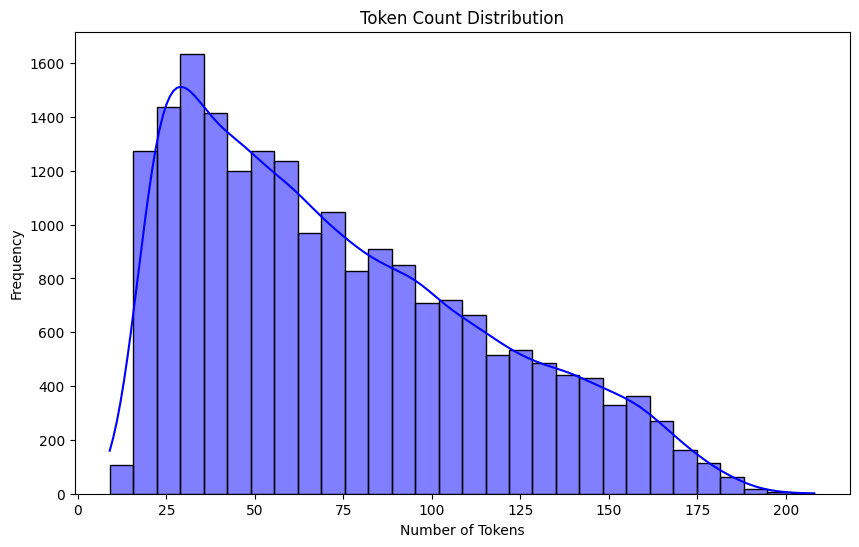

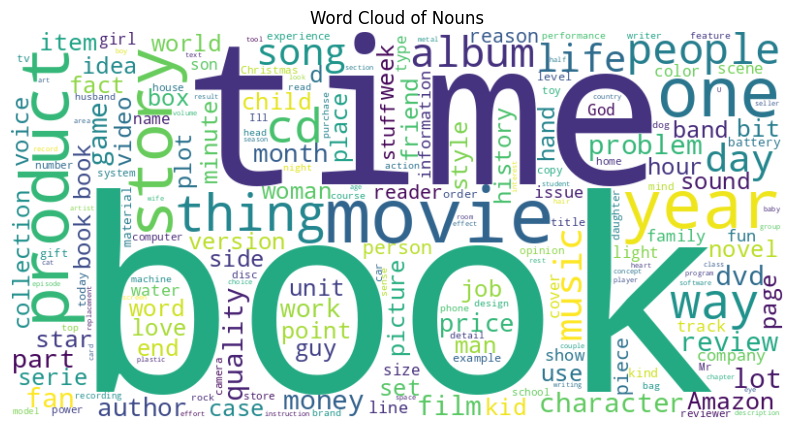

In [11]:
from google.colab import drive
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# File path to the dataset in Google Drive
file_path = '/content/drive/My Drive/ML/amazon_train.csv'

# Load the dataset without headers if headers are not properly defined
data = pd.read_csv(file_path, header=None)
data.columns = ['ID', 'Review', 'Text']  # Assign meaningful column names

# Display structure of the dataset
print("Columns in the dataset:\n", data.columns)
print(data.head())

# --- Sampling 200 Rows ---
# Sample 200 rows randomly before further processing
# increased to 20,000 as 200 was too small
data = data.sample(n=20_000, random_state=42)

# Display the sampled data
print("Sampled data:\n", data.head())

# Function to clean text
def clean(text):
    text = re.sub(r'https*://[^\s]+', "", str(text))  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    return text.strip()

# Clean text and calculate token counts
data["Text_Cleaned"] = data["Text"].apply(lambda x: clean(x) if isinstance(x, str) else "")
data["Token_Count"] = data["Text_Cleaned"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Load spaCy for NLP
nlp = spacy.load("en_core_web_sm")

# Extract linguistic features
data["Nouns"] = ""
data["Adjectives"] = ""
data["Verbs"] = ""
data["Lemmas"] = ""

for i, row in data.iterrows():
    if i % 100 == 0:
        print(f"Processing row {i}...")

    text = row["Text_Cleaned"]
    if isinstance(text, str) and len(text) > 0:
        doc = nlp(text)
        nouns = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "PROPN"]]
        adjectives = [token.lemma_ for token in doc if token.pos_ == "ADJ"]
        verbs = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        lemmas = [token.lemma_ for token in doc]

        data.at[i, "Nouns"] = " ".join(nouns)
        data.at[i, "Adjectives"] = " ".join(adjectives)
        data.at[i, "Verbs"] = " ".join(verbs)
        data.at[i, "Lemmas"] = " ".join(lemmas)

# --- Exploratory Analysis and Visualizations ---
# Token count distribution
plt.figure(figsize=(10, 6))
sns.histplot(data["Token_Count"], bins=30, kde=True, color="blue")
plt.title("Token Count Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


# Word Cloud of Nouns
nouns = " ".join(data["Nouns"].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(nouns)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Nouns")
plt.show()




In [12]:
# --- Feature Engineering ---
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Reinitialize LabelEncoder
le = LabelEncoder()
data["Encoded_Review"] = le.fit_transform(data["Review"])

# Check initial class distribution
print("Initial class distribution:")
print(data["Encoded_Review"].value_counts())

# Remove classes with fewer than 5 samples
data = data.groupby("Encoded_Review").filter(lambda x: len(x) >= 5)

print("Updated class distribution (after filtering):")
print(data["Encoded_Review"].value_counts())

# Stratified split with an increased test size
X_train, X_test, y_train, y_test = train_test_split(
    data["Text_Cleaned"], data["Encoded_Review"], test_size=0.3, stratify=data["Encoded_Review"], random_state=42
)

print("Class distribution in y_train:")
print(pd.Series(y_train).value_counts())
print("Class distribution in y_test:")
print(pd.Series(y_test).value_counts())

# 1. Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = bow_vectorizer.fit_transform(X_train).toarray()
X_test_bow = bow_vectorizer.transform(X_test).toarray()

# 2. TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

print("Feature engineering with Bag of Words and TF-IDF done.")

# 3. Word2Vec Embeddings
word2vec_model = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4)
X_train_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in text.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for text in X_train])
X_test_word2vec = np.array([np.mean([word2vec_model.wv[word] for word in text.split() if word in word2vec_model.wv] or [np.zeros(100)], axis=0) for text in X_test])

print("Feature engineering with Word2Vec embeddings done.")


Initial class distribution:
Encoded_Review
3735     50
3756     48
4515     27
5885     19
4130     19
         ..
17691     1
17796     1
14902     1
11992     1
4029      1
Name: count, Length: 18590, dtype: int64
Updated class distribution (after filtering):
Encoded_Review
3735     50
3756     48
4515     27
5885     19
4130     19
         ..
10198     5
11411     5
5916      5
10509     5
9117      5
Name: count, Length: 100, dtype: int64
Class distribution in y_train:
Encoded_Review
3735     35
3756     34
4515     19
5885     13
4130     13
         ..
16368     3
11958     3
1819      3
14990     3
3534      3
Name: count, Length: 100, dtype: int64
Class distribution in y_test:
Encoded_Review
3735     15
3756     14
4515      8
4130      6
5885      6
         ..
3683      1
15159     1
4011      1
3812      1
11392     1
Name: count, Length: 100, dtype: int64
Feature engineering with Bag of Words and TF-IDF done.
Feature engineering with Word2Vec embeddings done.


In [13]:
from torch.utils.data import DataLoader
import torch
import numpy as np
from tqdm import tqdm  # Progress bar library
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)

# BERT batching function with progress bar
def bert_batch_encode(texts, batch_size=32):
    dataloader = DataLoader(list(texts), batch_size=batch_size, shuffle=False)
    embeddings = []
    total_batches = len(dataloader)  # Total number of batches
    with tqdm(total=total_batches, desc="Encoding Batches") as pbar:  # Initialize progress bar
        for batch in dataloader:
            # Tokenize the batch and move inputs to the correct device
            inputs = tokenizer(list(batch), return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)
            with torch.no_grad():
                outputs = bert_model(**inputs)
            # Mean pooling on the last hidden state
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)
            pbar.update(1)  # Update the progress bar
    return np.array(embeddings)

# Generate BERT embeddings for train and test datasets with progress
print("Processing X_train...")
X_train_bert = bert_batch_encode(X_train, batch_size=32)

print("Processing X_test...")
X_test_bert = bert_batch_encode(X_test, batch_size=32)



Processing X_train...


Encoding Batches: 100%|██████████| 19/19 [05:02<00:00, 15.90s/it]


Processing X_test...


Encoding Batches: 100%|██████████| 9/9 [02:04<00:00, 13.84s/it]


In [14]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
from tqdm import tqdm  # For progress bar

# Load the ELMo model from TensorFlow Hub
elmo = hub.load("https://tfhub.dev/google/elmo/3")

# Batch processing function for ELMo embeddings
def elmo_encode_batch(sentences, batch_size=32):
    """
    Generates ELMo embeddings for a list of sentences in batches.
    Args:
        sentences (list): List of sentences (strings).
        batch_size (int): Number of sentences to process per batch.
    Returns:
        numpy array: Averaged ELMo embeddings for each sentence.
    """
    embeddings = []
    for i in tqdm(range(0, len(sentences), batch_size), desc="Generating ELMo Embeddings in Batches"):
        batch = sentences[i:i + batch_size]
        # Generate embeddings for the current batch
        embedding = elmo.signatures["default"](tf.constant(batch))["elmo"].numpy()
        # Average word embeddings to produce sentence embeddings
        embeddings.extend(embedding.mean(axis=1))
    return np.array(embeddings)

# Generate ELMo embeddings for training and test sets in batches
print("Processing Training Data:")
X_train_elmo = elmo_encode_batch(X_train, batch_size=2)

print("\nProcessing Test Data:")
X_test_elmo = elmo_encode_batch(X_test, batch_size=2)

# Output the shapes of the embeddings
print("\nELMo Embeddings Shape for Training Data:", X_train_elmo.shape)
print("ELMo Embeddings Shape for Test Data:", X_test_elmo.shape)


Processing Training Data:


Generating ELMo Embeddings in Batches: 100%|██████████| 303/303 [39:09<00:00,  7.75s/it]



Processing Test Data:


Generating ELMo Embeddings in Batches: 100%|██████████| 130/130 [15:47<00:00,  7.29s/it]


ELMo Embeddings Shape for Training Data: (605, 1024)
ELMo Embeddings Shape for Test Data: (260, 1024)


In [15]:
# Install Flair
!pip install flair

# Import required modules
from flair.embeddings import TransformerDocumentEmbeddings
from flair.data import Sentence
import numpy as np

# Load Flair's Transformer-based embeddings
flair_embedding = TransformerDocumentEmbeddings('bert-base-uncased')

# Function to generate Flair embeddings for a list of sentences
def flair_encode(sentences):
    embeddings = []
    for sentence_text in sentences:
        sentence = Sentence(sentence_text)
        flair_embedding.embed(sentence)
        embeddings.append(sentence.get_embedding().detach().numpy())
    return np.array(embeddings)

# # Example sentences
# X_train = ["This is an example sentence.", "Flair embeddings are easy to use."]
# X_test = ["Another example sentence.", "TensorFlow models are flexible."]

# Generate Flair embeddings
X_train_flair = flair_encode(X_train)
X_test_flair = flair_encode(X_test)

# Check the shape of the embeddings
print("Flair Embeddings Shape for Training Data:", X_train_flair.shape)
print("Flair Embeddings Shape for Test Data:", X_test_flair.shape)


Flair Embeddings Shape for Training Data: (605, 768)
Flair Embeddings Shape for Test Data: (260, 768)


In [18]:
# # --- Baseline Model & Benchmark ---
# def evaluate_model(X_train, X_test, y_train, y_test, model):
#     """Train and evaluate a model, returning overall precision, recall, and F1-score."""
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     # Add zero_division=0 to handle undefined metrics
#     report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
#     # Extract overall metrics (macro avg for balanced evaluation)
#     overall_metrics = {
#         "Precision": report["macro avg"]["precision"],
#         "Recall": report["macro avg"]["recall"],
#         "F1-Score": report["macro avg"]["f1-score"],
#     }
#     return overall_metrics
# print("done")

# # Logistic Regression
# lr_bow = evaluate_model(X_train_bow, X_test_bow, y_train, y_test, LogisticRegression())
# lr_tfidf = evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test, LogisticRegression())
# lr_word2vec = evaluate_model(X_train_word2vec, X_test_word2vec, y_train, y_test, LogisticRegression())
# lr_bert = evaluate_model(X_train_bert, X_test_bert, y_train, y_test, LogisticRegression())
# lr_elmo = evaluate_model(X_train_elmo, X_test_elmo, y_train, y_test, LogisticRegression(max_iter=1000))
# lr_flair = evaluate_model(X_train_flair, X_test_flair, y_train, y_test, LogisticRegression(max_iter=1000))

# # Decision Tree
# dt_bow = evaluate_model(X_train_bow, X_test_bow, y_train, y_test, DecisionTreeClassifier())
# dt_tfidf = evaluate_model(X_train_tfidf, X_test_tfidf, y_train, y_test, DecisionTreeClassifier())
# dt_word2vec = evaluate_model(X_train_word2vec, X_test_word2vec, y_train, y_test, DecisionTreeClassifier())
# dt_bert = evaluate_model(X_train_bert, X_test_bert, y_train, y_test, DecisionTreeClassifier())
# dt_elmo = evaluate_model(X_train_elmo, X_test_elmo, y_train, y_test, DecisionTreeClassifier())
# dt_flair = evaluate_model(X_train_flair, X_test_flair, y_train, y_test, DecisionTreeClassifier())

# print("done")

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import warnings

# Suppress convergence warnings (optional)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Evaluation Function ---
def evaluate_model(X_train, X_test, y_train, y_test, model):
    """
    Train and evaluate a model, returning overall precision, recall, and F1-score.
    Args:
        X_train, X_test: Feature sets for training and testing.
        y_train, y_test: Labels for training and testing.
        model: Model to train and evaluate.
    Returns:
        dict: Overall precision, recall, and F1-score (macro average).
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # Handle undefined metrics with zero_division=0
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    overall_metrics = {
        "Precision": report["macro avg"]["precision"],
        "Recall": report["macro avg"]["recall"],
        "F1-Score": report["macro avg"]["f1-score"],
    }
    return overall_metrics

# Assume X_train_* and X_test_* are the feature matrices for different embeddings
# Standardize the features (if applicable)
scaler = StandardScaler()
X_train_bow_scaled = scaler.fit_transform(X_train_bow)
X_test_bow_scaled = scaler.transform(X_test_bow)

X_train_tfidf_scaled = scaler.fit_transform(X_train_tfidf)
X_test_tfidf_scaled = scaler.transform(X_test_tfidf)

X_train_word2vec_scaled = scaler.fit_transform(X_train_word2vec)
X_test_word2vec_scaled = scaler.transform(X_test_word2vec)

X_train_bert_scaled = scaler.fit_transform(X_train_bert)
X_test_bert_scaled = scaler.transform(X_test_bert)

X_train_elmo_scaled = scaler.fit_transform(X_train_elmo)
X_test_elmo_scaled = scaler.transform(X_test_elmo)

X_train_flair_scaled = scaler.fit_transform(X_train_flair)
X_test_flair_scaled = scaler.transform(X_test_flair)

# --- Logistic Regression ---
print("Running Logistic Regression...")
lr_bow = evaluate_model(X_train_bow_scaled, X_test_bow_scaled, y_train, y_test, LogisticRegression(max_iter=1000))
lr_tfidf = evaluate_model(X_train_tfidf_scaled, X_test_tfidf_scaled, y_train, y_test, LogisticRegression(max_iter=1000))
lr_word2vec = evaluate_model(X_train_word2vec_scaled, X_test_word2vec_scaled, y_train, y_test, LogisticRegression(max_iter=1000))
lr_bert = evaluate_model(X_train_bert_scaled, X_test_bert_scaled, y_train, y_test, LogisticRegression(max_iter=1000))
lr_elmo = evaluate_model(X_train_elmo_scaled, X_test_elmo_scaled, y_train, y_test, LogisticRegression(max_iter=1000))
lr_flair = evaluate_model(X_train_flair_scaled, X_test_flair_scaled, y_train, y_test, LogisticRegression(max_iter=1000))

# --- Decision Tree ---
print("Running Decision Tree...")
dt_bow = evaluate_model(X_train_bow_scaled, X_test_bow_scaled, y_train, y_test, DecisionTreeClassifier())
dt_tfidf = evaluate_model(X_train_tfidf_scaled, X_test_tfidf_scaled, y_train, y_test, DecisionTreeClassifier())
dt_word2vec = evaluate_model(X_train_word2vec_scaled, X_test_word2vec_scaled, y_train, y_test, DecisionTreeClassifier())
dt_bert = evaluate_model(X_train_bert_scaled, X_test_bert_scaled, y_train, y_test, DecisionTreeClassifier())
dt_elmo = evaluate_model(X_train_elmo_scaled, X_test_elmo_scaled, y_train, y_test, DecisionTreeClassifier())
dt_flair = evaluate_model(X_train_flair_scaled, X_test_flair_scaled, y_train, y_test, DecisionTreeClassifier())

# --- Print Results ---
print("\n--- Results ---")
print("Logistic Regression (Bag of Words):", lr_bow)
print("Logistic Regression (TF-IDF):", lr_tfidf)
print("Logistic Regression (Word2Vec):", lr_word2vec)
print("Logistic Regression (BERT):", lr_bert)
print("Logistic Regression (ELMo):", lr_elmo)
print("Logistic Regression (Flair):", lr_flair)

print("\nDecision Tree (Bag of Words):", dt_bow)
print("Decision Tree (TF-IDF):", dt_tfidf)
print("Decision Tree (Word2Vec):", dt_word2vec)
print("Decision Tree (BERT):", dt_bert)
print("Decision Tree (ELMo):", dt_elmo)
print("Decision Tree (Flair):", dt_flair)

print("\nDone.")



Running Logistic Regression...
Running Decision Tree...

--- Results ---
Logistic Regression (Bag of Words): {'Precision': 0.0466826420890937, 'Recall': 0.02846428571428571, 'F1-Score': 0.029292839757612765}
Logistic Regression (TF-IDF): {'Precision': 0.029309139784946238, 'Recall': 0.02567857142857143, 'F1-Score': 0.021203281901380565}
Logistic Regression (Word2Vec): {'Precision': 0.024230158730158727, 'Recall': 0.025142857142857144, 'F1-Score': 0.020612987283718992}
Logistic Regression (BERT): {'Precision': 0.021004079254079253, 'Recall': 0.02860714285714286, 'F1-Score': 0.02265823065823066}
Logistic Regression (ELMo): {'Precision': 0.03488461538461538, 'Recall': 0.0345, 'F1-Score': 0.02884494773519164}
Logistic Regression (Flair): {'Precision': 0.016737940907748418, 'Recall': 0.021011904761904763, 'F1-Score': 0.016260597332025905}

Decision Tree (Bag of Words): {'Precision': 0.023864219114219112, 'Recall': 0.02463095238095238, 'F1-Score': 0.022274891774891774}
Decision Tree (TF-IDF)


--- Overall Model Performance ---

               Model  Precision    Recall  F1-Score
0  Bag of Words (LR)   0.046683  0.028464  0.029293
1        TF-IDF (LR)   0.029309  0.025679  0.021203
2      Word2Vec (LR)   0.024230  0.025143  0.020613
3          BERT (LR)   0.021004  0.028607  0.022658
4  Bag of Words (DT)   0.023864  0.024631  0.022275
5        TF-IDF (DT)   0.019364  0.022548  0.019377
6      Word2Vec (DT)   0.014409  0.016381  0.014657
7          BERT (DT)   0.018988  0.020298  0.017749


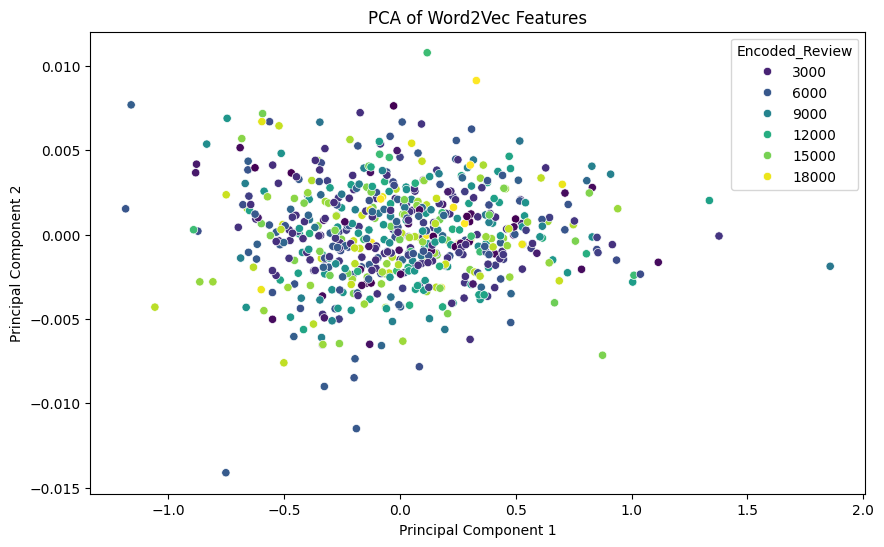

In [19]:


# --- Summary Table ---
# Consolidate results into a summary table
summary_data = pd.DataFrame({
    "Model": ["Bag of Words (LR)", "TF-IDF (LR)", "Word2Vec (LR)", "BERT (LR)",
              "Bag of Words (DT)", "TF-IDF (DT)", "Word2Vec (DT)", "BERT (DT)"],
    "Precision": [lr_bow["Precision"], lr_tfidf["Precision"], lr_word2vec["Precision"], lr_bert["Precision"],
                  dt_bow["Precision"], dt_tfidf["Precision"], dt_word2vec["Precision"], dt_bert["Precision"]],
    "Recall": [lr_bow["Recall"], lr_tfidf["Recall"], lr_word2vec["Recall"], lr_bert["Recall"],
               dt_bow["Recall"], dt_tfidf["Recall"], dt_word2vec["Recall"], dt_bert["Recall"]],
    "F1-Score": [lr_bow["F1-Score"], lr_tfidf["F1-Score"], lr_word2vec["F1-Score"], lr_bert["F1-Score"],
                 dt_bow["F1-Score"], dt_tfidf["F1-Score"], dt_word2vec["F1-Score"], dt_bert["F1-Score"]],
})

# Display the summary table
print("\n--- Overall Model Performance ---\n")
print(summary_data)

# PCA Visualization for Word2Vec Features
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_word2vec)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette="viridis")
plt.title("PCA of Word2Vec Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()